# Logistic Regression with PySpark

## Download dataset

In [ ]:
! wget -P dataset https://www.dropbox.com/s/d0t4lgw1gsq9t2r/pima-indians-diabetes.csv

In [1]:
! ls -lah dataset

total 32K
drwxr-xr-x 2 root root 4.0K Feb 10 01:50 .
drwxr-xr-x 1 root root 4.0K Feb 10 02:10 ..
-rw-r--r-- 1 root root  24K Feb 10 01:50 pima-indians-diabetes.csv


In [2]:
! wc -l dataset/pima-indians-diabetes.csv

768 dataset/pima-indians-diabetes.csv


In [3]:
! head dataset/pima-indians-diabetes.csv

Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
6,148,72,35,0,33.6,0.627,50,1
1,85,66,29,0,26.6,0.351,31,0
8,183,64,0,0,23.3,0.672,32,1
1,89,66,23,94,28.1,0.167,21,0
0,137,40,35,168,43.1,2.288,33,1
5,116,74,0,0,25.6,0.201,30,0
3,78,50,32,88,31,0.248,26,1
10,115,0,0,0,35.3,0.134,29,0
2,197,70,45,543,30.5,0.158,53,1


Dataset description

*   Pregnancies: Number of times pregnant
*   Glucose: Plasma glucose concentration a 2 hours in an oral glucose tolerance test
*   BloodPressure: Diastolic blood pressure (mm Hg)
*   SkinThickness: Triceps skin fold thickness (mm)
*   Insulin: 2-Hour serum insulin (mu U/ml)
*   BMI: Body mass index (weight in kg/(height in m)^2)
*   DiabetesPedigreeFunction: Diabetes pedigree function
*   Age: Age (years)
*   Outcome: Class variable --> 0 : no diabetes, 1: diabetes

https://www.kaggle.com/uciml/pima-indians-diabetes-database


## Apache Spark Installation

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://www-us.apache.org/dist/spark/spark-2.4.7/spark-2.4.7-bin-hadoop2.7.tgz 
!tar xf spark-2.4.7-bin-hadoop2.7.tgz
!pip install -q findspark

In [4]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.7-bin-hadoop2.7"

In [5]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [6]:
print("Spark version : " + spark.version)

Spark version : 2.4.7


In [7]:
import sys
print("Python version : " + sys.version)

Python version : 3.6.9 (default, Oct  8 2020, 12:12:24) 
[GCC 8.4.0]


In [8]:
#sc=spark.sparkContext
#sqlContext=SQLContext(sc)

NameError: ignored

## Read File

In [9]:
df_diabetes = spark.read.csv(path='dataset/pima-indians-diabetes.csv', 
                            sep=',', 
                            header = True, 
                            inferSchema = True)

In [10]:
df_diabetes.count()

768

In [11]:
df_diabetes.show(4)

+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin| BMI|DiabetesPedigreeFunction|Age|Outcome|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|          6|    148|           72|           35|      0|33.6|                   0.627| 50|      1|
|          1|     85|           66|           29|      0|26.6|                   0.351| 31|      0|
|          8|    183|           64|            0|      0|23.3|                   0.672| 32|      1|
|          1|     89|           66|           23|     94|28.1|                   0.167| 21|      0|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
only showing top 4 rows



In [12]:
df_diabetes.printSchema()

root
 |-- Pregnancies: integer (nullable = true)
 |-- Glucose: integer (nullable = true)
 |-- BloodPressure: integer (nullable = true)
 |-- SkinThickness: integer (nullable = true)
 |-- Insulin: integer (nullable = true)
 |-- BMI: double (nullable = true)
 |-- DiabetesPedigreeFunction: double (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Outcome: integer (nullable = true)



## Statistics

In [13]:
df_diabetes.describe().show()

+-------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------------+------------------+------------------+
|summary|       Pregnancies|          Glucose|     BloodPressure|     SkinThickness|           Insulin|               BMI|DiabetesPedigreeFunction|               Age|           Outcome|
+-------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------------+------------------+------------------+
|  count|               768|              768|               768|               768|               768|               768|                     768|               768|               768|
|   mean|3.8450520833333335|     120.89453125|       69.10546875|20.536458333333332| 79.79947916666667|31.992578124999977|      0.4718763020833327|33.240885416666664|0.3489583333333333|
| stddev|  3.36957806269887|31.97261819513622|19.355807170644777|15.95

In [14]:
numeric_features = [t[0] for t in df_diabetes.dtypes if t[1] == 'int']
df_diabetes.select(numeric_features).describe().toPandas()

,summary,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,Age,Outcome
0,count,768,768,768,768,768,768,768
1,mean,3.8450520833333335,120.89453125,69.10546875,20.536458333333332,79.79947916666667,33.240885416666664,0.3489583333333333
2,stddev,3.36957806269887,31.97261819513622,19.355807170644777,15.952217567727642,115.24400235133803,11.760231540678689,0.476951377242799
3,min,0,0,0,0,0,21,0
4,max,17,199,122,99,846,81,1


## Distribution of Target/Outcome

In [15]:
df_diabetes.groupby("Outcome").count().show()

+-------+-----+
|Outcome|count|
+-------+-----+
|      1|  268|
|      0|  500|
+-------+-----+



In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_context('notebook')

In [17]:
data = df_diabetes.groupby("Outcome").count().toPandas()

In [18]:
data.head()

,Outcome,count
0,1,268
1,0,500


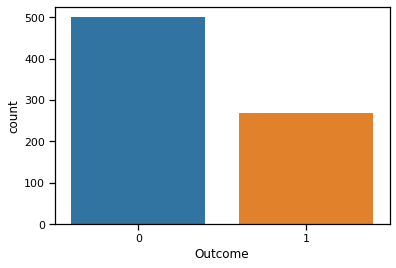

In [19]:
sns.barplot(x='Outcome', y='count', data=data)

## Distribution of Features

In [20]:
df_diabetes.groupby("Pregnancies").count().show()

+-----------+-----+
|Pregnancies|count|
+-----------+-----+
|         12|    9|
|          1|  135|
|         13|   10|
|          6|   50|
|          3|   75|
|          5|   57|
|         15|    1|
|          9|   28|
|         17|    1|
|          4|   68|
|          8|   38|
|          7|   45|
|         10|   24|
|         11|   11|
|         14|    2|
|          2|  103|
|          0|  111|
+-----------+-----+



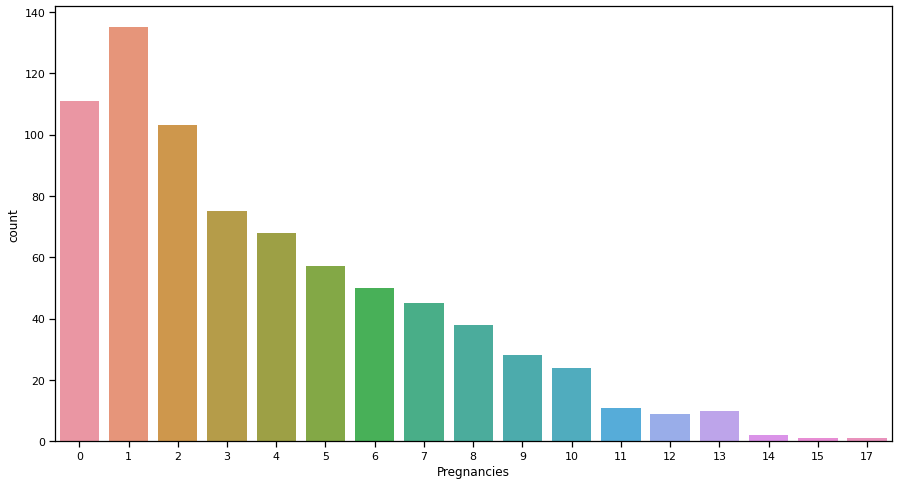

In [21]:
plt.figure(figsize=(15,8))
sns.barplot(x='Pregnancies', y='count', data=df_diabetes.groupby("Pregnancies").count().toPandas())

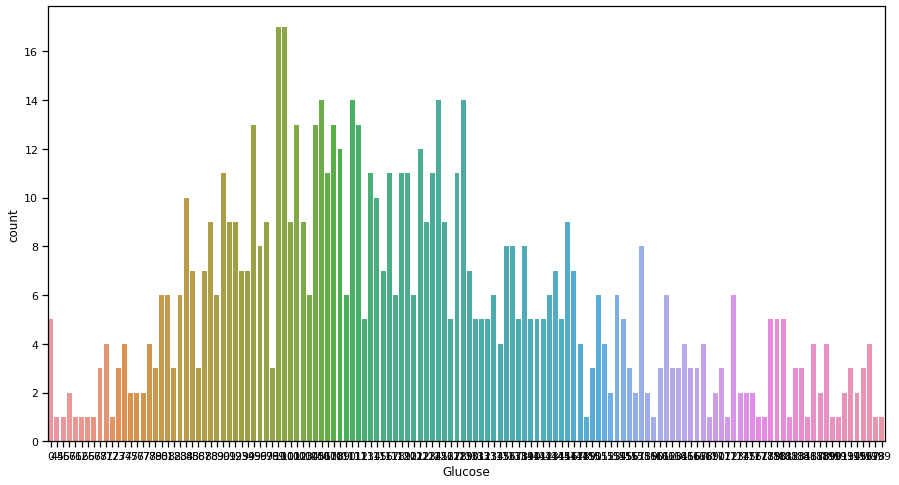

In [22]:
plt.figure(figsize=(15,8))
sns.barplot(x='Glucose', y='count', data=df_diabetes.groupby("Glucose").count().toPandas())

## Correlation

In [23]:
numeric_features = [t[0] for t in df_diabetes.dtypes if t[1] != 'string']
numeric_features_df=df_diabetes.select(numeric_features)
numeric_features_df.toPandas().head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [24]:
from pyspark.mllib.stat import Statistics

col_names =numeric_features_df.columns
features = numeric_features_df.rdd.map(lambda row: row[0:])
corr_mat=Statistics.corr(features, method="pearson")

corr_mat

array([[ 1.        ,  0.12945867,  0.14128198, -0.08167177, -0.07353461,
         0.01768309, -0.03352267,  0.54434123,  0.22189815],
       [ 0.12945867,  1.        ,  0.15258959,  0.05732789,  0.33135711,
         0.22107107,  0.1373373 ,  0.26351432,  0.4665814 ],
       [ 0.14128198,  0.15258959,  1.        ,  0.20737054,  0.08893338,
         0.28180529,  0.04126495,  0.23952795,  0.06506836],
       [-0.08167177,  0.05732789,  0.20737054,  1.        ,  0.43678257,
         0.3925732 ,  0.18392757, -0.11397026,  0.07475223],
       [-0.07353461,  0.33135711,  0.08893338,  0.43678257,  1.        ,
         0.19785906,  0.18507093, -0.04216295,  0.13054795],
       [ 0.01768309,  0.22107107,  0.28180529,  0.3925732 ,  0.19785906,
         1.        ,  0.14064695,  0.03624187,  0.29269466],
       [-0.03352267,  0.1373373 ,  0.04126495,  0.18392757,  0.18507093,
         0.14064695,  1.        ,  0.03356131,  0.17384407],
       [ 0.54434123,  0.26351432,  0.23952795, -0.11397026, -0

In [25]:
corr_df = pd.DataFrame(corr_mat)
corr_df.index, corr_df.columns = col_names, col_names

corr_df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Pregnancies,1.000000,0.129459,0.141282,-0.081672,-0.073535,0.017683,-0.033523,0.544341,0.221898
Glucose,0.129459,1.000000,0.152590,0.057328,0.331357,0.221071,0.137337,0.263514,0.466581
BloodPressure,0.141282,0.152590,1.000000,0.207371,0.088933,0.281805,0.041265,0.239528,0.065068
SkinThickness,-0.081672,0.057328,0.207371,1.000000,0.436783,0.392573,0.183928,-0.113970,0.074752
Insulin,-0.073535,0.331357,0.088933,0.436783,1.000000,0.197859,0.185071,-0.042163,0.130548
BMI,0.017683,0.221071,0.281805,0.392573,0.197859,1.000000,0.140647,0.036242,0.292695
DiabetesPedigreeFunction,-0.033523,0.137337,0.041265,0.183928,0.185071,0.140647,1.000000,0.033561,0.173844
Age,0.544341,0.263514,0.239528,-0.113970,-0.042163,0.036242,0.033561,1.000000,0.238356
Outcome,0.221898,0.466581,0.065068,0.074752,0.130548,0.292695,0.173844,0.238356,1.000000


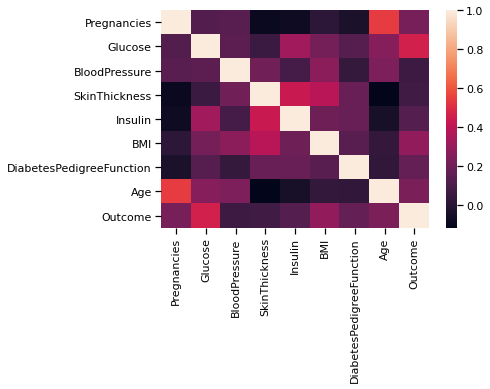

In [26]:
sns.heatmap(corr_df, 
        xticklabels=corr_df.columns,
        yticklabels=corr_df.columns)

## Feature Extraction

In [27]:
from pyspark.ml.feature import VectorAssembler

inputCols = [
 'Glucose',
 'Insulin',
 'BMI'
]
outputCol = "features"

df_va = VectorAssembler(inputCols = inputCols, outputCol = outputCol)

df_diabetes = df_va.transform(df_diabetes)
#df.select(['features']).toPandas().head(5)

In [28]:
df_diabetes.show(5)

+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+------------------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin| BMI|DiabetesPedigreeFunction|Age|Outcome|          features|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+------------------+
|          6|    148|           72|           35|      0|33.6|                   0.627| 50|      1|  [148.0,0.0,33.6]|
|          1|     85|           66|           29|      0|26.6|                   0.351| 31|      0|   [85.0,0.0,26.6]|
|          8|    183|           64|            0|      0|23.3|                   0.672| 32|      1|  [183.0,0.0,23.3]|
|          1|     89|           66|           23|     94|28.1|                   0.167| 21|      0|  [89.0,94.0,28.1]|
|          0|    137|           40|           35|    168|43.1|                   2.288| 33|      1|[137.0,168.0,43.1]|
+-----------+-------+-------------+-------------

## Model Training

In [29]:
train, test = df_diabetes.randomSplit([0.8, 0.2], seed = 2018)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 627
Test Dataset Count: 141


In [30]:
train.show(5)

+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+----------------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin| BMI|DiabetesPedigreeFunction|Age|Outcome|        features|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+----------------+
|          0|     57|           60|            0|      0|21.7|                   0.735| 67|      0| [57.0,0.0,21.7]|
|          0|     67|           76|            0|      0|45.3|                   0.194| 46|      0| [67.0,0.0,45.3]|
|          0|     73|            0|            0|      0|21.1|                   0.342| 25|      0| [73.0,0.0,21.1]|
|          0|     74|           52|           10|     36|27.8|                   0.269| 22|      0|[74.0,36.0,27.8]|
|          0|     78|           88|           29|     40|36.9|                   0.434| 21|      0|[78.0,40.0,36.9]|
+-----------+-------+-------------+-------------+-------+----+--

In [31]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(featuresCol = 'features', labelCol = 'Outcome', maxIter=5)
lrModel = lr.fit(train)

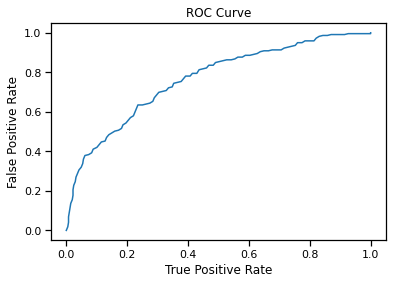

Training set areaUnderROC: 0.7642470230101175


In [32]:
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

## Evaluate Model

In [33]:
predictions = lrModel.transform(test)
predictions.select('Outcome', 'features',  'rawPrediction', 'prediction', 'probability').toPandas().head(5)

,Outcome,features,rawPrediction,prediction,probability
0,0,"[93.0, 72.0, 43.4]","[1.9513884609502188, -1.9513884609502188]",0.0,"[0.8755979604378447, 0.12440203956215536]"
1,0,"[100.0, 110.0, 46.8]","[1.83765499102173, -1.83765499102173]",0.0,"[0.8626711312269036, 0.13732886877309636]"
2,0,"[102.0, 0.0, 25.1]","[1.034657754147693, -1.034657754147693]",0.0,"[0.737817901637271, 0.26218209836272893]"
3,1,"[105.0, 0.0, 27.9]","[1.0299693295798837, -1.0299693295798837]",0.0,"[0.7369099496895418, 0.26309005031045823]"
4,0,"[106.0, 148.0, 39.4]","[1.3937119666069586, -1.3937119666069586]",0.0,"[0.801184176322565, 0.19881582367743492]"


In [34]:
accuracy = predictions.filter(predictions.Outcome == predictions.prediction).count() / float(predictions.count())
print("Accuracy : ",accuracy)

Accuracy :  0.6879432624113475


In [35]:
from sklearn.metrics import confusion_matrix
class_names=[1.0,0.0]
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Outcome label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[20 29]
 [15 77]]


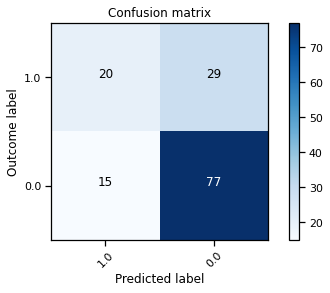

In [36]:
y_true = predictions.select("Outcome")
y_true = y_true.toPandas()

y_pred = predictions.select("prediction")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_names)
#cnf_matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix')
plt.show()